# Mount your own Google Drive (to import folders and files)

In [1]:
!rm -r sample_data
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [93]:
!rm -r web_2class_SPLIT/test/b*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, pickle, random, sys
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
from collections import OrderedDict, deque, Counter
import cv2 
from google.colab.patches import cv2_imshow
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils import model_zoo

ImageFile.LOAD_TRUNCATED_IMAGES = True
use_cuda = torch.cuda.is_available()

In [3]:
# import the dataset zip folder and unzip it
!cp 'gdrive/My Drive/web_2class_SPLIT.zip' .
!unzip -qq web_2class_SPLIT.zip
!rm web_2class_SPLIT.zip 
!rm web_2class_SPLIT/.DS_Store   # for MAC 
!rm -r __MACOSX   # for MAC

# Define Dataloaders

In [82]:
!rm -r */*/.ipynb_checkpoints

In [94]:
root_dir = "web_2class_SPLIT/"  # 2 classes: gun, knife
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(root_dir + 'train', transform)
valid_data = datasets.ImageFolder(root_dir + 'valid', transform)
test_data = datasets.ImageFolder(root_dir + 'test', transform)

print("Class2idx: ", train_data.class_to_idx)
print('Train images :', len(train_data))
print('Valid images :', len(valid_data))
print('Test images :', len(test_data))

batch_size = 16
dataloaders = {}

dataloaders['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['valid'] = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Class2idx:  {'gun': 0, 'knife': 1}
Train images : 1724
Valid images : 215
Test images : 215


# Define Model

In [5]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Define Loss 

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train the Model

In [ ]:
def train(n_epochs, 
          dataloaders, 
          model,  
          criterion, 
          optimizer,
          use_cuda):
    
    classes = dataloaders['train'].dataset.classes
    n_classes = len(classes)
    if use_cuda:
      model = model.cuda()

    loss_dict = {}
    loss_dict['train'], loss_dict['valid'], loss_dict['valid_acc'] = [], [], []
    valid_loss_min = np.Inf
    prev_save = ""
    print("criterion: {}".format(criterion))

    for e in range(1, n_epochs + 1):
      start = time.time()
      train_loss, valid_loss, n_corr = 0., 0., 0
      
      #################  TRAIN THE MODEL  #################
      model.train()
      for data, target in dataloaders['train']:
        if use_cuda:
          data = data.cuda() 
          target = target.cuda()   # shape: [batch_size]

        optimizer.zero_grad()
        output = model(data)    # shape: [batch_size, n_classes]  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
                          
      #################  VALIDATE THE MODEL  #################
      model.eval()
      for data, target in dataloaders['valid']:
        if use_cuda:
          data = data.cuda() 
          target = target.cuda()   # shape: [batch_size]

        output = model(data)    # [batch_size, n_classes]  
        loss = criterion(output, target)  
        valid_loss += loss.item()
        output = output.cpu().detach().numpy()
        n_corr += int(sum([np.argmax(pred)==target[i] for i, pred in enumerate(output)]))

      train_loss = train_loss / len(dataloaders['train'].dataset)
      valid_loss = valid_loss / len(dataloaders['valid'].dataset)
      valid_acc = n_corr/len(dataloaders['valid'].dataset)

      loss_dict['train'].append(train_loss)
      loss_dict['valid'].append(valid_loss)        
      loss_dict['valid_acc'].append(valid_acc)

      ##  Log result each epoch
      print('Epoch: %d/%d\t Train Loss: %.5f\t Valid Loss: %.5f\t Valid Acc: %.4f\t elapsed time: %.1fs'%(e, n_epochs, train_loss, valid_loss, valid_acc, time.time()-start))

      ##  Save model if the current validation loss is lower than the previous validation loss
      if valid_loss < valid_loss_min:
        if prev_save:
          os.remove("model" + prev_save + ".pt")
          os.remove("loss_dict" + prev_save + ".pkl")
        prev_save = "_" + str(e) 
        torch.save(model.state_dict(), "model" + prev_save + ".pt")
        pickle.dump(loss_dict, open("loss_dict" + prev_save + ".pkl", "wb"))
        valid_loss_min = valid_loss
            
    return loss_dict, model

In [ ]:
# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00002)
# Train
n_epochs = 10 
loss_dict, model = train(n_epochs=n_epochs, 
                         dataloaders=dataloaders, 
                         model=model, 
                         criterion=criterion,
                         use_cuda=use_cuda,
                         optimizer=optimizer)

criterion: CrossEntropyLoss()
Epoch: 1/10	 Train Loss: 0.01115	 Valid Loss: 0.00160	 Valid Acc: 1.0000	 elapsed time: 23.8s
Epoch: 2/10	 Train Loss: 0.00265	 Valid Loss: 0.00102	 Valid Acc: 0.9907	 elapsed time: 23.9s
Epoch: 3/10	 Train Loss: 0.00155	 Valid Loss: 0.00113	 Valid Acc: 0.9953	 elapsed time: 23.8s
Epoch: 4/10	 Train Loss: 0.00056	 Valid Loss: 0.00052	 Valid Acc: 1.0000	 elapsed time: 23.7s
Epoch: 5/10	 Train Loss: 0.00055	 Valid Loss: 0.00059	 Valid Acc: 0.9953	 elapsed time: 23.8s
Epoch: 6/10	 Train Loss: 0.00086	 Valid Loss: 0.00089	 Valid Acc: 1.0000	 elapsed time: 24.0s
Epoch: 7/10	 Train Loss: 0.00019	 Valid Loss: 0.00084	 Valid Acc: 0.9953	 elapsed time: 24.1s
Epoch: 8/10	 Train Loss: 0.00052	 Valid Loss: 0.00063	 Valid Acc: 0.9953	 elapsed time: 23.9s
Epoch: 9/10	 Train Loss: 0.00029	 Valid Loss: 0.00028	 Valid Acc: 1.0000	 elapsed time: 23.8s
Epoch: 10/10	 Train Loss: 0.00023	 Valid Loss: 0.00038	 Valid Acc: 1.0000	 elapsed time: 23.8s


# Load the Best Model
from the iteration that resulted in the lowest validation loss

In [ ]:
model.load_state_dict(torch.load("model_9.pt"))

<All keys matched successfully>

In [6]:
# if loading from a saved model
!cp gdrive/MyDrive/model_9.pt .
model.load_state_dict(torch.load("model_9.pt"))

<All keys matched successfully>

# Plot Losses

In [ ]:
def plot_losses(loss_dict):
    plt.plot(loss_dict["train"])
    plt.plot(loss_dict["valid"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["training loss", "valid loss"])

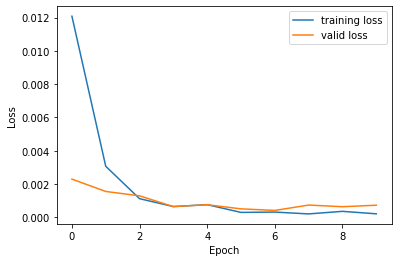

In [ ]:
plot_losses(loss_dict)

# Test the model on the test set
* Save test predictions and labels
* Show incorrectly classified images


In [142]:
def test_model(model, test_dataloader, class2idx=None, plot_incorrect=False, use_cuda=use_cuda):
  ''' return_probs : If True, also return the dict of the classified class's 
                    prediction probability for each input image '''
  if use_cuda:
    model.cuda()
  model.eval()
  class2idx = class2idx if class2idx else test_dataloader.dataset.class_to_idx 
  idx2class = {class2idx[key]:key for key in class2idx}

  with torch.no_grad():
    for i, (data, target) in enumerate(test_dataloader):
      data = data.cuda() if use_cuda else data
      output = model(data).cpu().numpy() # shape: [batch, n_classes] 
      # save logits (=raw model outputs)
      logits = output if i==0 else np.concatenate((logits, output), axis=0)  
      # save class probabilities   
      probs_batch = np.array([[np.exp(l)/sum(np.exp(batch)) for l in batch] for batch in output]) 
      probs = probs_batch if i==0 else np.concatenate((probs, probs_batch), axis=0)  
      # save class predictions
      preds_batch = np.argmax(output, axis=1)
      preds = preds_batch if i==0 else np.concatenate((preds, preds_batch), axis=0) 
      # save target labels 
      test_labels = target.numpy() if i==0 else np.concatenate((test_labels, target.numpy()), axis=0)    

      if plot_incorrect:  # plot incorrectly classified images
        is_pred_correct = preds_batch==target.numpy()
        if 0 in is_pred_correct:
          for incorr_i in [j for j, val in enumerate(is_pred_correct) if val==0]:
            plt.imshow(np.transpose(data[incorr_i].cpu().numpy(), (1,2,0)))
            plt.title("True label: {}, Predicted label: {}".format(idx2class[target.numpy()[incorr_i]], idx2class[preds[incorr_i]]))
            plt.show()
  
  return preds, test_labels, logits, probs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


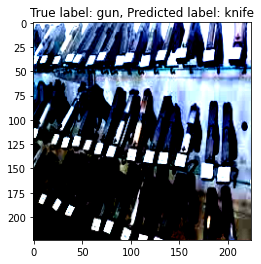

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


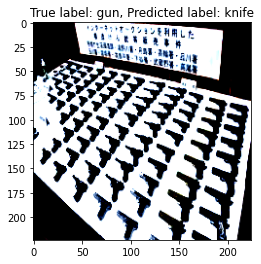

In [ ]:
preds, labels, logits, probs = test_model(model, dataloaders['test'], test_data.class_to_idx, plot_incorrect=True)

Maybe the model is confused when it sees a grid of a large number of guns instead of a single gun. This is possible as most training images contain in a single gun. 

# Show Confusion Matrix
Using the predictions and labels from the previous step

In [347]:
def show_confusion_matrix(predictions, labels, dataset, pred_classes=None, idx_swap_dict=None):
    class2idx = dataset.class_to_idx
    if pred_classes is None:
      pred_classes = dataset.classes
    if idx_swap_dict:
      predictions = [idx_swap_dict.get(p) for p in predictions]
    
    cm = confusion_matrix(y_true=labels, y_pred=predictions)

    # adjust confusion matrix dimensions if # of classes of test images != # of predictions classes
    if len(dataset.classes) > len(pred_classes) :
      cm = np.concatenate((np.expand_dims(cm[:,class2idx['gun']], axis=1), 
                           np.expand_dims(cm[:,class2idx['knife']], axis=1)), axis=1)
    elif len(dataset.classes) < len(pred_classes) :
      cm = cm[:len(dataset.classes)]

    cm_ratios = cm/cm.sum(axis=1)[:,None]

    plt.figure(figsize=(5,5))
    plt.imshow(cm_ratios, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=17)
    plt.colorbar()
    plt.yticks(range(len(dataset.classes)), dataset.classes, rotation=90, fontsize=12)
    plt.xticks(range(len(set(preds))), pred_classes, fontsize=12)
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)  

    # fill in the cells with numbers & percentages
    for i in range(len(cm)):
      for j in range(len(cm[i])):  
        if cm_ratios[i][j] >= 0.7:
          plt.text(j, i, str(cm[i][j])+"\n(%.1f%%)"%(100*cm_ratios[i][j]), 
                  horizontalalignment='center', color='white', fontsize=15)  
        else:
          plt.text(j, i, str(cm[i][j])+"\n(%.1f%%)"%(100*cm_ratios[i][j]), 
                  horizontalalignment='center', color='black', fontsize=15)  
    plt.show()

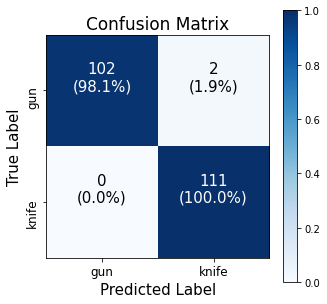

In [167]:
show_confusion_matrix(preds, labels, test_data)

# Classify a single image

In [188]:
def classify_one_image(img_path, model, classes):   ### Test a SINGLE image ###
    img = Image.open(img_path).convert('RGB')       
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img = transform(img)[:3, :, :].unsqueeze(0)  
    # plot image  
    plt.imshow(np.transpose(img.squeeze(0).numpy(), (1,2,0)))
    #plt.axis("off")
    plt.show()
    model.eval()
    img = img.cuda() if use_cuda else img
    logits = model(img).cpu().detach().numpy() # [batch, n_classes]
    probs = np.array([[np.exp(l)/sum(np.exp(batch)) for l in batch] for batch in logits]).squeeze(0)
    plt.figure()
    # plot class probabilities for the image
    f, ax = plt.subplots(figsize=(4, 2))
    sns.set_color_codes("pastel")
    logits_df = pd.DataFrame(probs, index=classes, columns=["probability"]).sort_values("probability",ascending=False)
    sns.barplot(x="probability", y=logits_df.index, data=logits_df,label="Total",color="b")
    plt.title('class probabilities')

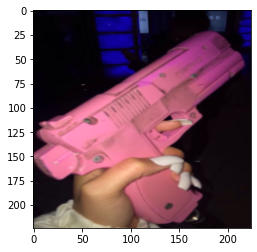

<Figure size 432x288 with 0 Axes>

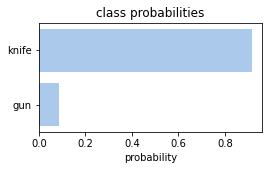

In [ ]:
classify_one_image("test_gun.jpeg", model, train_data.classes)

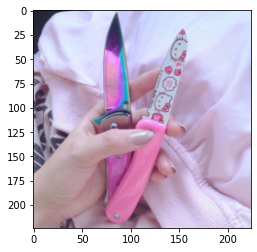

<Figure size 432x288 with 0 Axes>

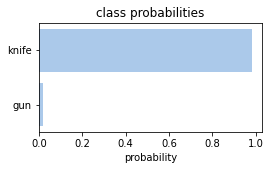

In [ ]:
classify_one_image("test_knife.png", model, train_data.classes)

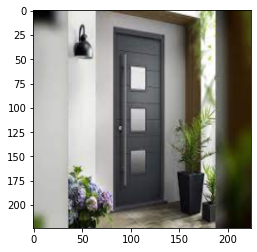

<Figure size 432x288 with 0 Axes>

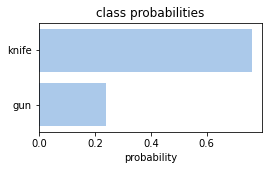

In [190]:
classify_one_image("door.jpeg", model, train_data.classes)

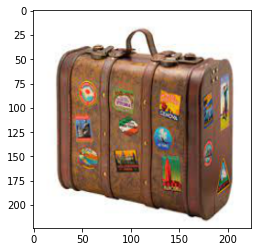

<Figure size 432x288 with 0 Axes>

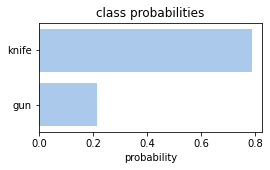

In [176]:
classify_one_image("bag.jpeg", model, train_data.classes)

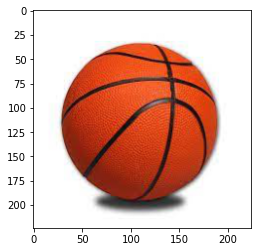

<Figure size 432x288 with 0 Axes>

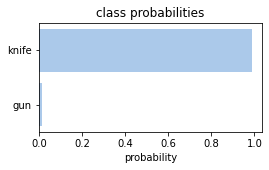

In [192]:
classify_one_image("ball.jpeg", model, train_data.classes)

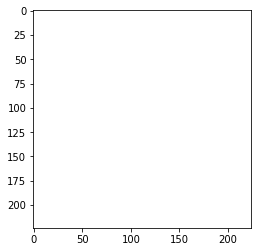

<Figure size 432x288 with 0 Axes>

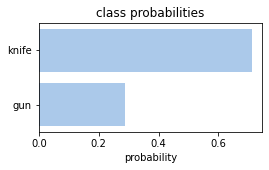

In [189]:
classify_one_image("blank.png", model, train_data.classes)

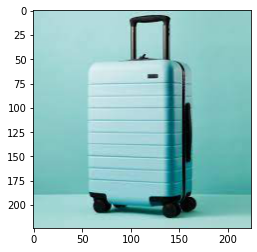

<Figure size 432x288 with 0 Axes>

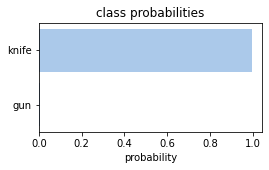

In [193]:
classify_one_image("bagg.jpeg", model, train_data.classes)

# Test Xray Images

## 2 classes : Gun and Knife

In [7]:
!cp 'gdrive/My Drive/Xray_2cls_NOdupl_cropped.zip' .
!unzip -qq Xray_2cls_NOdupl_cropped.zip
!rm Xray_2cls_NOdupl_cropped.zip 
!rm Xray_2cls_NO_dupl_cropped/knife/Kitchen*
!rm Xray_2cls_NO_dupl_cropped/knife/Cutter*

In [8]:
!ls Xray_2cls_NO_dupl_cropped/gun/|wc -l
!ls Xray_2cls_NO_dupl_cropped/knife/|wc -l

117
33


In [9]:
root_dir = "Xray_2cls_NO_dupl_cropped/"  # 2 classes: gun, knife
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
                               # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Xray_data_2cls = datasets.ImageFolder(root_dir, transform)
print("Class2idx: ", Xray_data_2cls.class_to_idx)
print('# of images :', len(Xray_data_2cls))

batch_size = 16
Xray_dataloader_2cls = DataLoader(Xray_data_2cls, batch_size=batch_size, shuffle=True)

Class2idx:  {'gun': 0, 'knife': 1}
# of images : 150


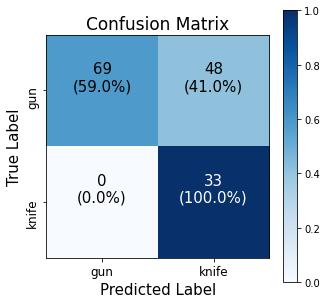

In [322]:
preds, labels, logits, probs = test_model(model, Xray_dataloader_2cls, Xray_data_2cls.class_to_idx, plot_incorrect=False)
show_confusion_matrix(preds, labels, Xray_data_2cls)

## 3 classes : Benign, Gun, and Knife

In [95]:
!cp 'gdrive/My Drive/Xray-3cls_small.zip' .  
!unzip -qq Xray-3cls_small.zip
!rm Xray-3cls_small.zip 
# remove Kitchen knife & Cutter knife images
!mkdir kitchen_knife
!mkdir cutter_knife
!mv Xray-3cls_small/knife/Kitchen* kitchen_knife/
!mv Xray-3cls_small/knife/Cutter* cutter_knife/
!mv Xray-3cls_small/benign_inch Xray-3cls_small/benign

In [11]:
root_dir = "Xray-3cls_small"    # 3 classes: benign, gun, knife
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
                               # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Xray_data_3cls = datasets.ImageFolder(root_dir, transform)
print("Class2idx: ", Xray_data_3cls.class_to_idx)
print('# of images :', len(Xray_data_3cls))

batch_size = 16
Xray_dataloader_3cls = DataLoader(Xray_data_3cls, batch_size=batch_size, shuffle=True)

Class2idx:  {'benign': 0, 'gun': 1, 'knife': 2}
# of images : 450


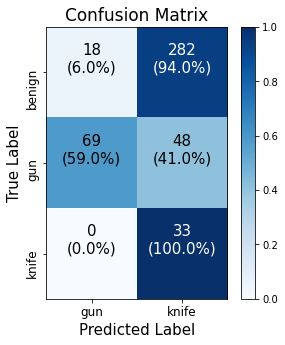

In [307]:
preds, labels, logits, probs = test_model(model, Xray_dataloader_3cls, plot_incorrect=False)
show_confusion_matrix(preds, labels, Xray_data_3cls, pred_classes=['gun', 'knife'], idx_swap_dict={0:1, 1:2})

## benign only

In [ ]:
!mkdir Xray_benign
!cp -r Xray-3cls_small/benign Xray_benign/

In [323]:
root_dir = "Xray_benign"             # 3 classes: benign, gun, knife
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
                               # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Xray_benign_data = datasets.ImageFolder(root_dir, transform)
print("Class2idx: ", Xray_benign_data.class_to_idx)
print('# of images :', len(Xray_benign_data))

batch_size = 16
Xray_benign_dataloader = DataLoader(Xray_benign_data, batch_size=batch_size, shuffle=True)

Class2idx:  {'benign': 0}
# of images : 300


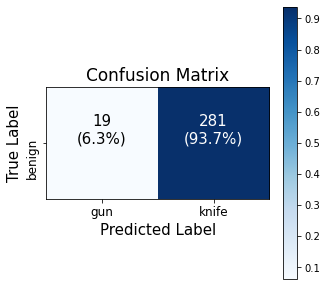

In [367]:
preds, labels, logits, probs = test_model(model, Xray_benign_dataloader, plot_incorrect=False)
show_confusion_matrix(preds, labels, Xray_benign_data, pred_classes=['gun', 'knife'])

In [383]:
gun_predicted_ids = [i for i, p in enumerate(preds) if p==0]
gun_probs = [p[0] for i, p in enumerate(probs)]# if i in gun_predicted_ids]
knife_predicted_ids = [i for i, p in enumerate(preds) if p==1]
knife_probs = [p[1] for i, p in enumerate(probs)]# if i in knife_predicted_ids]

In [384]:
gun_probs_df = pd.DataFrame()
gun_probs_df["probability"]=gun_probs
knife_probs_df = pd.DataFrame()
knife_probs_df["probability"]=knife_probs

### Plot knife probabilities

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


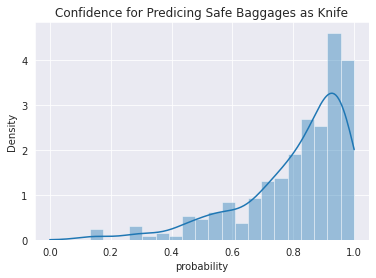

In [386]:
with sns.axes_style("darkgrid"):
  sns.distplot(knife_probs_df['probability'], hist=True, kde=True, norm_hist=True,
              bins=20, kde_kws={'clip': (0.0, 1.0)})
  plt.title("Confidence for Predicing Safe Baggages as Knife")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


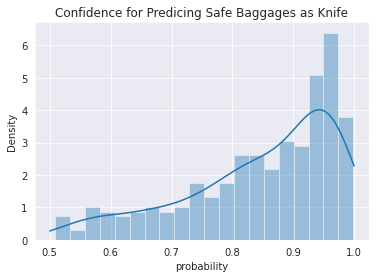

In [371]:
with sns.axes_style("darkgrid"):
  sns.distplot(knife_probs_df['probability'], hist=True, kde=True, norm_hist=True,
              bins=20, kde_kws={'clip': (0.5, 1.0)})
  plt.title("Confidence for Predicing Safe Baggages as Knife")

### Plot **gun** probabilities

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


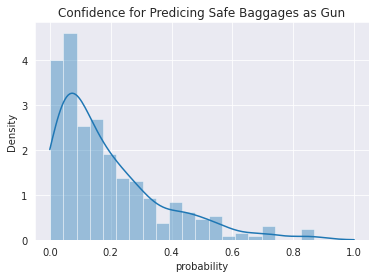

In [387]:
with sns.axes_style("darkgrid"): 
  sns.distplot(gun_probs_df['probability'], hist=True, kde=True, norm_hist=True,
              bins=20, kde_kws={'clip': (0.0, 1.0)})
  plt.title("Confidence for Predicing Safe Baggages as Gun")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


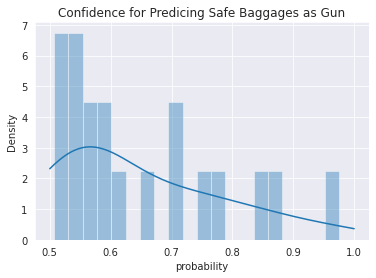

In [372]:
with sns.axes_style("darkgrid"): 
  sns.distplot(gun_probs_df['probability'], hist=True, kde=True, norm_hist=True,
              bins=20, kde_kws={'clip': (0.5, 1.0)})
  plt.title("Confidence for Predicing Safe Baggages as Gun")

# t-SNE Plots

In [111]:
def scale_to_01_range(x):  # scale and move the coordinates so they fit [0; 1] range
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def plot_tsne(dataloader, encoder, title, domain=False, dataloader_tgt=None, plot_img=False, figsize=None):
    encoder = encoder.cuda().eval()
    # t-SNE plot with images
    if plot_img:
        for i, (data, target, fname) in enumerate(dataloader):
            data = data.cuda() 
            with torch.no_grad():
                outputs = encoder(data)
                outputs = torch.flatten(outputs, 1)
            outputs = outputs.cpu().numpy()
            features = outputs if i==0 else np.concatenate((features, outputs), axis=0) 
            labels = target if i==0 else np.concatenate((labels, target), axis=0)
            fnames = list(fname) if i==0 else fnames + list(fname)
    # t-SNE plot with coloured dots
    else:
        for i, (data, target) in enumerate(dataloader):
            data = data.cuda() 
            with torch.no_grad():
                outputs = encoder(data)
                outputs = torch.flatten(outputs, 1)
            outputs = outputs.cpu().numpy()
            features = outputs if i==0 else np.concatenate((features, outputs), axis=0) 
            labels = target if i==0 else np.concatenate((labels, target), axis=0)
    
    print("# of samples : {} \n feature-dim : {}".format(features.shape[0], features.shape[1]))
    tsne = TSNE(n_components=2).fit_transform(features)

    # extract x and y coordinates representing the positions of the images on T-SNE plot
    figsize=(6,4) if figsize is None else figsize
    fig = plt.figure(figsize=figsize)

    tx, ty = tsne[:, 0], tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    
    classes = dataloader.dataset.classes if domain==False else ["target", "source"] #[0,1]
    class2idx = {c:i for i, c in enumerate(classes)}

    colors = ['#ff4000', '#0080ff', '#00ffff', '#ffbf00', '#FF00FF', '#008000', '#80ff00', '#8000ff','#33ff00',
              '#95d47a','#85e3ff','#ffaaff', '#cceedd','#fff176', '#cceedd', '#0080ff']  # pastel colours
    colors_per_class = {label:colors[i] for i, label in enumerate(classes)}

    if plot_img:
        width = 4000
        height = 3000
        max_dim = 100
        full_image = Image.new('RGBA', (width, height))
        img_paths = fnames

    for label in colors_per_class:
        indices = [i for i, l in enumerate(labels) if l == class2idx[label]]
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        
        if plot_img:
            current_img_paths = np.take(img_paths, indices)
            for img, x, y in zip(current_img_paths, current_tx, current_ty):
                tile = Image.open(img)
                rs = max(1, tile.width/max_dim, tile.height/max_dim)
                tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
                full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
        else:
            color = colors_per_class[label]  #np.array(colors_per_class[label], dtype=np.float)/255
            ax = fig.add_subplot(111)
            ax.scatter(current_tx, current_ty, c=color, label=label, alpha=0.5)

    if plot_img:
        plt.figure(figsize = (20,15))
        plt.imshow(full_image)
        plt.title(title)
    else:
        ax.legend(classes, loc='best')
        plt.title(title)
        plt.show()

## Web Images (2 classes : gun vs. knife)

# of samples : 215 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


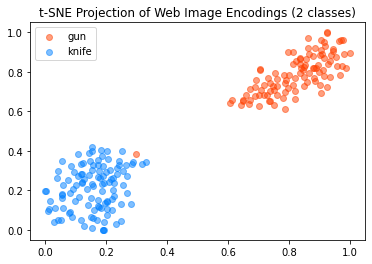

In [ ]:
encoder = nn.Sequential(*[model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool])
plot_tsne(dataloaders['test'], encoder, title="t-SNE Projection of Web Image Encodings (2 classes)")

## Xray Images (2 classes : gun vs. knife)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# of samples : 150 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


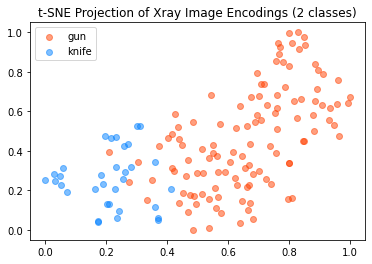

In [22]:
plot_tsne(Xray_dataloader_2cls, encoder, title="t-SNE Projection of Xray Image Encodings (2 classes)")

## Xray Images (3 classes : gun vs. knife vs. benign)

# of samples : 450 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


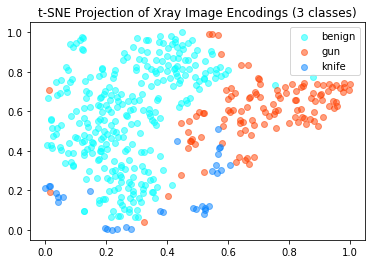

In [27]:
plot_tsne(Xray_dataloader_3cls, encoder, title="t-SNE Projection of Xray Image Encodings (3 classes)")

## Web and Xray Images Together

In [ ]:
# Make a folder to contain both web and Xray images 
!mkdir web_xray
!mkdir web_xray/xray_gun
!mkdir web_xray/xray_knife
!mkdir web_xray/web_gun
!mkdir web_xray/web_knife

!cp web_2class_SPLIT/test/gun/* web_xray/web_gun/
!cp web_2class_SPLIT/test/knife/* web_xray/web_knife/
!cp Xray-3cls_small/gun/* web_xray/xray_gun/
!cp Xray-3cls_small/knife/* web_xray/xray_knife/

!mkdir web_xray/xray_benign
!cp Xray-3cls_small/benign/* web_xray/xray_benign/
#!cp -r benign/test/benign web_xray/

In [ ]:
# 3 classes : gun, knife, benign
data_path = 'web_xray'
num_workers = 0
batch_size = 16
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

combined_dataset = ImageFolderWithPaths(data_path, transform) # resize only
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print("Classes: ", combined_dataset.classes)
print("Number of Xray images : {}    Number of Xray batches : {}  (batch size={})".format(len(combined_dataset), len(combined_dataloader), batch_size))

Classes:  ['web_gun', 'web_knife', 'xray_benign', 'xray_gun', 'xray_knife']
Number of Xray images : 665    Number of Xray batches : 42  (batch size=16)


# of samples : 665 
 feature-dim : 2048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


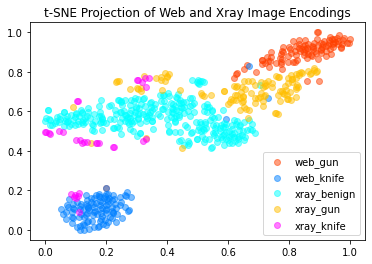

In [ ]:
plot_tsne(combined_dataloader, encoder, title="t-SNE Projection of Web and Xray Image Encodings")

# of samples : 665 
 feature-dim : 2048


<Figure size 432x288 with 0 Axes>

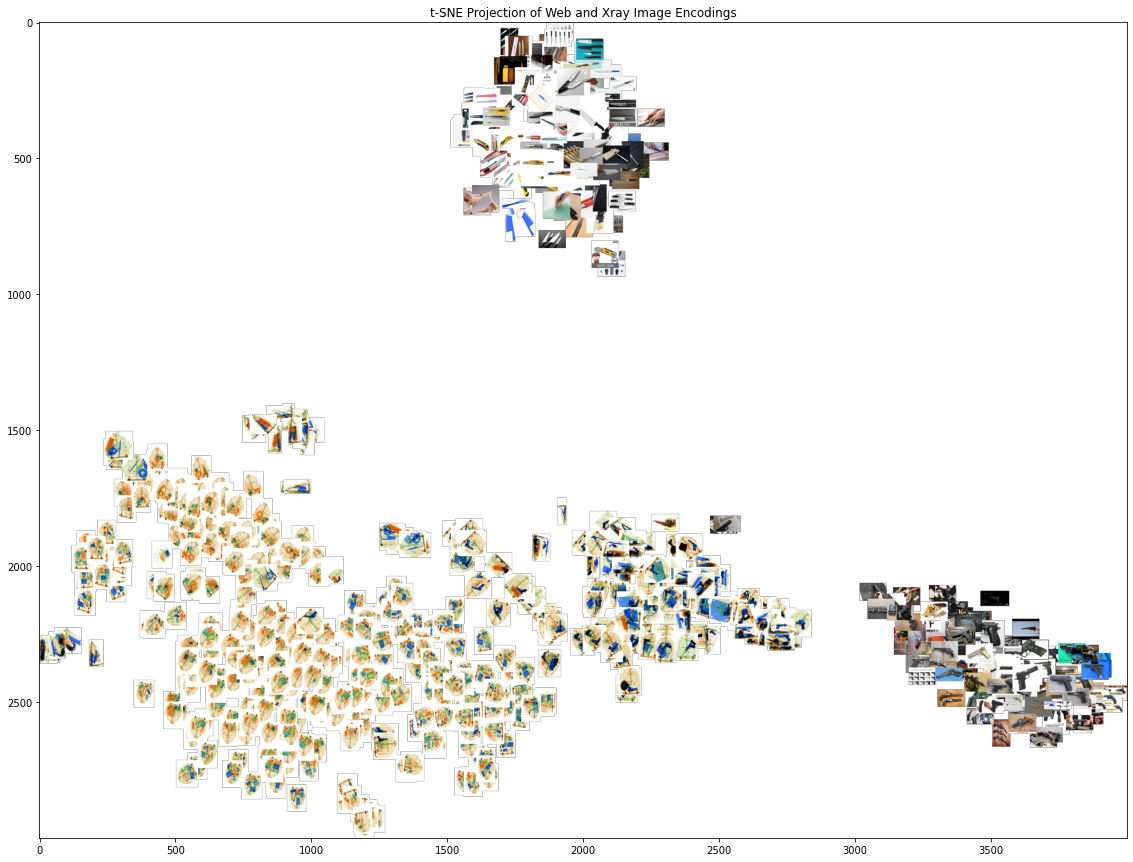

In [ ]:
# Image t-SNE
plot_tsne(combined_dataloader, encoder, title="t-SNE Projection of Web and Xray Image Encodings", plot_img=True)